In [8]:
# testing for exact TN charge gap parameter
import sys
sys.path.append("..")

from dmet.model import hubbard
from pyscf import fci
from pyscf.scf import hf
import numpy as np
from cpskit.fci import ci_slater
import scipy.linalg as la
from eomdp.fcicis import get_fciao_cisd_wfns, get_fciao_cisd_aabb_wfns
from pyscf import ao2mo

def hs_1imp(wfnlst, nocc, nvir, h1e, eri):  # for fci wave-function list

    nstate = len(wfnlst)
    
    h = np.zeros((nstate, nstate))
    s = np.zeros((nstate, nstate))

    for i in range(nstate):

        cibra = wfnlst[i]
        for j in range(nstate):

            ciket = wfnlst[j]

            s[i,j] += np.einsum("ij,ij->", cibra.conj(), ciket)
            dm1, dm2 = fci.direct_spin1.trans_rdm12(cibra, ciket, nocc+nvir, (nocc,nocc))
            h[i,j] += np.einsum("ij,ij->", h1e, dm1) + .5 * np.einsum("ijkl,ijkl->", eri, dm2)

    return h, s

def FCI_Atomic(mf): 
    # imitating pyscf.fci.__init__.FCI(), reset h1e, eri and ci0 to SITE basis.

    mol = mf.mol
    mo_c = mf.mo_coeff
    h1e = mf.get_hcore()
    norb = mo_c.shape[1]
    eri = mf._eri
    nelec = getattr(mf, 'nelec', mol.nelec)
    mo_c_occ = mf.mo_coeff[:,np.where(mf.mo_occ==2)[0]]
    ci0 = ci_slater(norb, nelec, (mo_c_occ, mo_c_occ))

    fcisolver = fci.direct_spin1.FCISolver(mol)
    fcisolver_class = fcisolver.__class__
    class CISolver(fcisolver.__class__):
        def __init__(self, mol=None):
            fcisolver_class.__init__(self, mol)
            self.orbsym = None

        def kernel(self, h1e=h1e, eri=eri, norb=norb, nelec=nelec, ci0=ci0,
                   ecore=0., **kwargs):
            return fcisolver_class.kernel(self, h1e, eri, norb, nelec, ci0,
                                          ecore=ecore, **kwargs)
    
    cisolver = CISolver(mol)
    cisolver.__dict__.update(fcisolver.__dict__)
    cisolver.orbsym = None
    return cisolver

def get_cgintens(civec, norb, nelec):   
    r'''
    .. math::
        \xi = \sum\limits_{I^\alpha I^\beta} N(I^\alpha I^\beta) |\psi_{I^\alpha I^\beta}| ^ 2
    '''

    def get_cgnum(a, b, norb):

        c = a & b
        alst = [c&(2**x) for x in range(norb)]
        k = 0
        for i in alst:
            if i != 0: k += 1
        del alst
        return k

    strings = fci.cistring.make_strings(range(norb), nelec)

    intens = 0

    for a, stra in enumerate(strings):
        for b, strb in enumerate(strings):
            cgnum = get_cgnum(stra, strb, norb)
            psi = civec[a,b]
            intens += cgnum * psi * psi.conj()
    
    return intens

cisdaabb_int_lst = []
cisdaabb_ext_lst = []

cisd_int_lst = []
cisd_ext_lst = []

def calc(U, ny):
    mol = hubbard.HubbardMole(1, ny, 1, U)
    mol.nelectron = ny
    mf = hubbard.RHF_SpinHubbard(mol)
    nocc = nvir = nelec = ny // 2
    norb = ny
    mf.pbc = True
    mf.kernel()

    fcisolver = FCI_Atomic(mf)    # change ci into LO basis
    fullE, fullci = fcisolver.kernel(nroots=10)
    print("FCI = ", fullE)
    spinoplst = [round(fci.spin_op.spin_square(cis, norb, (nelec, nelec))[0]) for cis in fullci]
    print("S^2 of FCI vectors: ", spinoplst)
    ci = fullci[0]


    eri = ao2mo.restore(1, mf._eri, ny)
    h1e = mf.get_hcore()

    wfnlst = get_fciao_cisd_aabb_wfns(ci, nocc, nvir, mf.mo_coeff)
    exact_H, exact_S = hs_1imp(wfnlst, nocc, nvir, h1e, eri)

    wS_exact, vS_exact = la.eigh(exact_S)
    mask = wS_exact > 1e-5
    S_proj = vS_exact.T[mask] @ (exact_S+exact_S.T)/2 @ vS_exact[:,mask]
    H_proj = vS_exact.T[mask] @ (exact_H+exact_H.T)/2 @ vS_exact[:,mask]
    wHp_exact, vHp_exact = hf.eig(H_proj, S_proj)   # solve in truncated area

    print("Energy for FCICISDab = ", wHp_exact[:10])
    cisdaabb_ext_lst.append((wHp_exact[1] - wHp_exact[0]))

    coeff_in_basis = vS_exact[:,mask] @ vHp_exact

    wfnbasis = np.array(wfnlst)

    res_wfn = np.einsum("iab,ij->jab", wfnbasis, coeff_in_basis)
    spinoplst = [round(fci.spin_op.spin_square(res_wfn[i], norb, (nelec, nelec))[0]) for i in range(10)]
    print("S^2 for FCICISD = ", spinoplst)
    cgparam = get_cgintens(res_wfn[1], norb, nelec)
    print("Charge gap parameter of first triplet of FCICISDab: ", cgparam)
    cisdaabb_int_lst.append(cgparam)

ny = 6

ulst = np.linspace(1, 50, 50)
for U in ulst: calc(U, ny)


converged SCF energy = -6.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc6932d90> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6932700>


FCI =  [-6.60115829 -4.94491687 -4.76688967 -4.76688967 -4.69363464 -3.94241203
 -3.94241203 -3.72015979 -3.72015979 -3.21489276]
S^2 of FCI vectors:  [0, 2, 2, 2, 0, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-6.60115829 -4.94420069 -4.76560908 -4.76560908 -4.68597847 -4.54872194
 -4.41919933 -4.41919933 -4.28089422 -3.94026821]
S^2 for FCICISD =  [0, 2, 2, 2, 0, 2, 0, 0, 0, 2]
Charge gap parameter of first triplet of FCICISDab:  0.9422535808605027
converged SCF energy = -5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc651a8b0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc651a820>


FCI =  [-5.40945685 -4.0963821  -3.7565067  -3.7565067  -3.73239653 -3.12521306
 -3.12521306 -2.81625559 -2.81625559 -2.55682722]
S^2 of FCI vectors:  [0, 2, 2, 2, 0, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-5.40945685 -4.08639748 -3.73752838 -3.73752835 -3.63687352 -3.18329674
 -3.09800914 -3.09800912 -2.97224891 -2.97224887]
S^2 for FCICISD =  [0, 2, 2, 2, 0, 2, 2, 2, 0, 0]
Charge gap parameter of first triplet of FCICISDab:  0.7298680827800682
converged SCF energy = -3.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc651aa90> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc651a7f0>


FCI =  [-4.43335361 -3.42472915 -3.03176891 -2.9836321  -2.9836321  -2.5277994
 -2.5277994  -2.19421177 -2.19421177 -2.05196468]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-4.43335361 -3.38106235 -2.90501671 -2.90501667 -2.66679837 -2.4351562
 -2.43515618 -1.87557453 -1.59913701 -1.59913699]
S^2 for FCICISD =  [0, 2, 2, 2, 0, 2, 2, 2, 0, 0]
Charge gap parameter of first triplet of FCICISDab:  0.5334076993003213
converged SCF energy = -2


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc686ac40> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc694a400>


FCI =  [-3.66870618 -2.89838147 -2.51637687 -2.42291126 -2.42291126 -2.09275383
 -2.09275383 -1.76902482 -1.76902482 -1.68447136]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-3.66870618 -2.78639665 -2.23774854 -2.23774842 -1.89796643 -1.89796637
 -1.65132375 -0.59723282 -0.55767326 -0.51466157]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 0, 2, 3, 0]
Charge gap parameter of first triplet of FCICISDab:  0.36804940826016813
converged SCF energy = -0.500000000000001


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc686ac40> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc69eea00>


FCI =  [-3.08770676 -2.48686651 -2.13127691 -2.02075922 -2.02075922 -1.7704692
 -1.7704692  -1.47113273 -1.47113273 -1.41746074]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-3.08770676 -2.28092783 -1.6984642  -1.69846411 -1.44247222 -1.44247214
 -0.56137855  0.20239727  0.58591194  0.58591198]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 0, 3, 0, 0]
Charge gap parameter of first triplet of FCICISDab:  0.24654331995581286
converged SCF energy = 1


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc651a7c0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-2.64851756 -2.16342845 -1.83805413 -1.72630329 -1.72630329 -1.52638607
 -1.52638607 -1.25456083 -1.25456083 -1.21874398]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-2.64851756 -1.8564505  -1.25393918 -1.25393905 -1.04108345 -1.04108306
  0.57002481  0.89652106  1.66848442  1.66848452]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 0, 3, 0, 0]
Charge gap parameter of first triplet of FCICISDab:  0.16587903212473354
converged SCF energy = 2.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc651a7c0>


FCI =  [-2.31185008 -1.9064776  -1.61020712 -1.50390603 -1.50390603 -1.33727193
 -1.33727193 -1.09138722 -1.09138722 -1.06650782]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-2.31185008 -1.50342844 -0.87952455 -0.87952447 -0.67900883 -0.67900872
  1.51624761  1.70409981  2.7037525   2.70375258]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 3, 0, 0, 0]
Charge gap parameter of first triplet of FCICISDab:  0.11459739796777797
converged SCF energy = 4


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc651a7c0>


FCI =  [-2.04813089 -1.69956461 -1.42956154 -1.33084623 -1.33084623 -1.18753787
 -1.18753787 -0.9646148  -0.9646148  -0.94674461]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-2.04813089 -1.20902663 -0.55760722 -0.5576072  -0.34770709 -0.34770697
  2.07277197  2.81937208  3.68776735  3.68776751]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 0, 1, 1]
Charge gap parameter of first triplet of FCICISDab:  0.08211688820175793
converged SCF energy = 5.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc69ee7f0>


FCI =  [-1.83692691 -1.53053306 -1.2836152  -1.19268607 -1.19268607 -1.06662144
 -1.06662144 -0.86356555 -0.86356555 -0.85035884]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-1.83692691 -0.96057758 -0.27537993 -0.27537987 -0.04121507 -0.04121483
  2.58123137  3.90864451  4.62770092  4.627701  ]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 0, 1, 1]
Charge gap parameter of first triplet of FCICISDab:  0.06126692248841865
converged SCF energy = 6.99999999999999


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc69ee7f0>


FCI =  [-1.66436273 -1.39049654 -1.1636734  -1.0800014  -1.0800014  -0.96724823
 -0.96724823 -0.78127889 -0.78127889 -0.77127646]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-1.66436273 -0.7475631  -0.02343116 -0.02343101  0.2451216   0.24512174
  3.05431532  4.97179927  5.53208601  5.53208621]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 0, 1, 1]
Charge gap parameter of first triplet of FCICISDab:  0.04764936494009413
converged SCF energy = 8.50000000000001


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6917d30>


FCI =  [-1.52090454 -1.27295063 -1.06359368 -0.98643373 -0.98643373 -0.88430984
 -0.88430984 -0.71305603 -0.71305603 -0.70531791]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-1.52090454 -0.56188793  0.20517688  0.20517706  0.51503883  0.51503889
  3.50137104  6.01135429  6.40799953  6.40799969]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 0, 1, 1]
Charge gap parameter of first triplet of FCICISDab:  0.03862101759551005
converged SCF energy = 9.99999999999999


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6917d30>


FCI =  [-1.39985748 -1.17309534 -0.97895849 -0.90755552 -0.90755552 -0.81414531
 -0.81414531 -0.65562453 -0.65562453 -0.64952636]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-1.39985748 -0.39749239  0.41557757  0.41557762  0.77153237  0.77153249
  3.92903749  7.03043754  7.26088925  7.26088928]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 0, 1, 1]
Charge gap parameter of first triplet of FCICISDab:  0.032575668645376685
converged SCF energy = 11.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6917d30>


FCI =  [-1.29640765 -1.08734713 -0.90653225 -0.84019614 -0.84019614 -0.75407849
 -0.75407849 -0.60664205 -0.60664205 -0.60175772]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-1.29640765 -0.24986229  0.61159585  0.61159588  1.01699392  1.01699434
  4.34201707  8.0320145   8.09493072  8.09493082]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 0, 1, 1]
Charge gap parameter of first triplet of FCICISDab:  0.028515163848268403
converged SCF energy = 13


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6917d30>


FCI =  [-1.2070146  -1.01299534 -0.84390277 -0.78202876 -0.78202876 -0.70211616
 -0.70211616 -0.5643914  -0.5643914  -0.56042296]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-1.2070146  -0.11561434  0.79610981  0.79611002  1.25333039  1.25333078
  4.74367584  8.91336822  8.91336847  9.01865239]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.02580330676745945
converged SCF energy = 14.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6917d30>


FCI =  [-1.12902061 -0.94796203 -0.78924142 -0.73130902 -0.73130902 -0.65674792
 -0.65674792 -0.5275869  -0.5275869  -0.52432148]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-1.12902061e+00  7.81342275e-03  9.71309590e-01  9.71309782e-01
  1.48206446e+00  1.48206452e+00  5.13646057e+00  9.71876255e+00
  9.71876263e+00  9.99249634e+00]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.024024366816559138
converged SCF energy = 16


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6917d30>


FCI =  [-1.06039367 -0.89063329 -0.74114039 -0.68670455 -0.68670455 -0.61681091
 -0.61681091 -0.49524801 -0.49524801 -0.49253056]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-1.06039367  0.12238582  1.13888181  1.13888194  1.70441716  1.70441734
  5.52218001 10.51316178 10.51316191 10.95531382]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.022900475837501807
converged SCF energy = 17.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6917d30>


FCI =  [-0.99955467 -0.83973995 -0.69850025 -0.64718082 -0.64718082 -0.58139686
 -0.58139686 -0.46661454 -0.46661454 -0.46433009]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.99955467  0.22962919  1.30014056  1.30014075  1.92137447  1.92137482
  5.90219402 11.29822387 11.2982241  11.90855704]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.022242027443829644
converged SCF energy = 19


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6917d30>


FCI =  [-0.94525851 -0.79427216 -0.66045119 -0.61192273 -0.61192273 -0.54978693
 -0.54978693 -0.44108841 -0.44108841 -0.4391504 ]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.94525851  0.33074406  1.45612266  1.45612273  2.13373736  2.13373747
  6.27754073 12.07530398 12.07530405 12.8534242 ]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.02191729407604192
converged SCF energy = 20.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6917d30>


FCI =  [-0.89651066 -0.75341762 -0.62629678 -0.58027968 -0.58027968 -0.52140534
 -0.52140534 -0.41819293 -0.41819293 -0.41653522]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.89651066  0.42668592  1.60765389  1.60765392  2.34216056  2.34216073
  6.6490255  12.84551905 12.84551909 13.79090873]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.021833258380081027
converged SCF energy = 22


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc7d1ba90> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8de417bdc0>


FCI =  [-0.85250734 -0.71651632 -0.5954733  -0.55172623 -0.55172623 -0.49578587
 -0.49578587 -0.39754361 -0.39754361 -0.39611503]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.85250734  0.51822359  1.7553999   1.75539993  2.54718427  2.54718445
  7.01728051 13.60979602 13.60979608 14.72184015]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.02192335202094641
converged SCF energy = 23.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc7d1ba90> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8de417bdc0>


FCI =  [-0.81259214 -0.68302692 -0.5675199  -0.52583354 -0.52583354 -0.47254717
 -0.47254717 -0.37882705 -0.37882705 -0.3775875 ]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.81259214  0.60598217  1.89990184  1.89990188  2.74925641  2.74925655
  7.38280887 14.36890971 14.36890976 15.64691667]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.02213933996279969
converged SCF energy = 25


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8de97acb80>


FCI =  [-0.77622382 -0.65250156 -0.54205633 -0.50224825 -0.50224825 -0.45137449
 -0.45137449 -0.3617853  -0.3617853  -0.36070304]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.77622382  0.69047487  2.04160405  2.04160407  2.94875135  2.94875139
  7.74601547 15.12351147 15.1235115  16.56673089]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.022445921935594772
converged SCF energy = 26.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8de97acb80>


FCI =  [-0.74295221 -0.62456674 -0.51876622 -0.48067662 -0.48067662 -0.43200583
 -0.43200583 -0.34620414 -0.34620414 -0.34525379]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.74295221  0.77212652  2.18087432  2.18087439  3.14598378  3.14598403
  8.10722945 15.8741519  15.87415213 17.48178979]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.02281703209259315
converged SCF energy = 28


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc6851a30> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8de417bdc0>


FCI =  [-0.71239989 -0.59890864 -0.49738427 -0.46087253 -0.46087253 -0.41422142
 -0.41422142 -0.33190427 -0.33190427 -0.33106534]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.71239989  0.85129198  2.3180192   2.3180193   3.34122053  3.34122077
  8.46672117 16.6212996  16.62129973 18.39252985]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.0232332945295456
converged SCF energy = 29.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc6851a30> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8de417bdc0>


FCI =  [-0.68424815 -0.57526177 -0.47768645 -0.44262822 -0.44262822 -0.39783559
 -0.39783559 -0.31873445 -0.31873445 -0.31799026]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.68424815  0.92826953  2.4532966   2.45329669  3.53468825  3.53468847
  8.82471441 17.36535406 17.36535421 19.29933047]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.02368021406899507
converged SCF energy = 31


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc75573d0>


FCI =  [-0.658226   -0.55340011 -0.45948228 -0.42576716 -0.42576716 -0.38269043
 -0.38269043 -0.30656629 -0.30656629 -0.30590316]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.658226    1.00331183  2.58692472  2.58692476  3.72658125  3.72658153
  9.18139629 18.10665882 18.106659   20.20252354]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.024146906414714467
converged SCF energy = 32.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc651aa00> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8de417bdc0>


FCI =  [-0.6341016  -0.53313003 -0.44260882 -0.41013839 -0.41013839 -0.36865085
 -0.36865085 -0.29529005 -0.29529005 -0.29469667]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.6341016   1.0766342   2.71908906  2.71908918  3.9170666   3.91706671
  9.53692388 18.84550978 18.84550998 21.10240027]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.02462517813206805
converged SCF energy = 34


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8e1977cd00>


FCI =  [-0.61167549 -0.51428478 -0.4269259  -0.39561206 -0.39561206 -0.35560056
 -0.35560056 -0.28481144 -0.28481144 -0.28427839]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.61167549  1.14842136  2.84994884  2.84994893  4.10628884  4.10628901
  9.89143052 19.58216391 19.58216403 21.99921967]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.025108856546941484
converged SCF energy = 35.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8de417bdc0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8e1977cd00>


FCI =  [-0.59077509 -0.49671998 -0.4123123  -0.38207589 -0.38207589 -0.34343899
 -0.34343899 -0.27504894 -0.27504894 -0.27456835]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.59077509  1.21883254  2.97964115  2.97964124  4.29437366  4.29437376
 10.24502953 20.31684296 20.31684303 22.89321048]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.025593300609025857
converged SCF energy = 37


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc6855b80> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8de417bdc0>


FCI =  [-0.57125039 -0.48031005 -0.39866265 -0.36943231 -0.36943231 -0.33207869
 -0.33207869 -0.26593177 -0.26593177 -0.26549699]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.57125039  1.28800571  3.10828437  3.10828451  4.4814306   4.4814309
 10.59781847 21.04974212 21.04974238 23.78457887]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.026075021604234326
converged SCF energy = 38.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc6855b20> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6855b80>


FCI =  [-0.55297034 -0.46494519 -0.38588492 -0.35759611 -0.35759611 -0.32144328
 -0.32144328 -0.25739814 -0.25739814 -0.25700354]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.55297034  1.3560612   3.23598143  3.23598169  4.66755604  4.6675565
 10.94988118 21.78103187 21.78103231 24.67350984]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.026551419075850735
converged SCF energy = 40


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc6855850> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6855b20>


FCI =  [-0.53581998 -0.45052907 -0.37389842 -0.34649257 -0.34649257 -0.31146574
 -0.31146574 -0.24939389 -0.24939389 -0.24903469]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.53581998  1.42310426  3.36282357  3.36282367  4.85283479  4.85283485
 11.30129104 22.51086289 22.51086299 25.56017118]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.02702058751005081
converged SCF energy = 41.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc686ac40> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc69b0fd0>


FCI =  [-0.51969805 -0.43697678 -0.36263207 -0.33605588 -0.33605588 -0.30208706
 -0.30208706 -0.24187135 -0.24187135 -0.24154345]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.51969805  1.48922703  3.48888841  3.48888846  5.037341    5.03734104
 11.65211088 23.23936675 23.23936678 26.44471209]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.027481119158516316
converged SCF energy = 43


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc651a940> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.50451499 -0.42421321 -0.35202304 -0.32622789 -0.32622789 -0.29325505
 -0.29325505 -0.2347884  -0.2347884  -0.23448828]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.50451499  1.55451118  3.6142464   3.61424646  5.2211412   5.2211413
 12.00239646 23.96666073 23.96666076 27.3272713 ]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.027932033166213094
converged SCF energy = 44.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc651a940> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.49019136 -0.41217169 -0.34201558 -0.31695697 -0.31695697 -0.28492341
 -0.28492341 -0.22810767 -0.22810767 -0.22783228]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.49019136  1.61902894  3.73895913  3.73895914  5.40429445  5.40429451
 12.3521965  24.6928489  24.69284895 28.20797395]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.028372654600023008
converged SCF energy = 46


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc686ac40> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc75573d0>


FCI =  [-0.47665636 -0.40079283 -0.33256006 -0.30819717 -0.30819717 -0.27705088
 -0.27705088 -0.22179591 -0.22179591 -0.22154262]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.47665636  1.68284442  3.86308113  3.86308117  5.58685319  5.58685326
 12.70155399 25.41802417 25.41802422 29.08693491]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.028802547028613706
converged SCF energy = 47.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc651a8e0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.46384678 -0.39002355 -0.32361215 -0.29990746 -0.29990746 -0.26960064
 -0.26960064 -0.21582343 -0.21582343 -0.21558994]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.46384678  1.74601478  3.98666117  3.98666124  5.76886457  5.7688646
 13.05050701 26.14226933 26.14226942 29.9642596 ]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.029221462105319503
converged SCF energy = 49


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc686ac40> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6856040>


FCI =  [-0.45170596 -0.37981629 -0.31513212 -0.29205106 -0.29205106 -0.26253968
 -0.26253968 -0.21016363 -0.21016363 -0.20994793]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.45170596  1.80859119  4.1097428   4.10974287  5.95037084  5.95037086
 13.39908942 26.8656585  26.86565855 30.8400449 ]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.029629296412716704
converged SCF energy = 50.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc6851a90> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.44018298 -0.37012828 -0.30708429 -0.28459493 -0.28459493 -0.25583832
 -0.25583832 -0.20479263 -0.20479263 -0.20459296]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.44018298  1.87061962  4.23236505  4.23236509  6.13141004  6.13141005
 13.74733147 27.58825854 27.5882586  31.71438035]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.03002605642561458
converged SCF energy = 52


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc651a8e0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.42923195 -0.360921   -0.2994365  -0.2775093  -0.2775093  -0.24946984
 -0.24946984 -0.1996889  -0.1996889  -0.19950371]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.42923195  1.93214131  4.35456287  4.35456291  6.31201649  6.31201654
 14.09526017 28.3101293  28.31012936 32.58734837]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.03041183166971851
converged SCF energy = 53.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc686ac40> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc6856310>


FCI =  [-0.4188114  -0.3521596  -0.29215971 -0.27076727 -0.27076727 -0.24341008
 -0.24341008 -0.194833   -0.194833   -0.19466093]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.4188114   1.99319338  4.47636782  4.47636797  6.49222127  6.49222141
 14.44289938 29.0313251  29.03132522 33.45902558]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.03078677314490639
converged SCF energy = 55


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8e1977cd00> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.40888378 -0.34381255 -0.28522759 -0.26434448 -0.26434448 -0.23763717
 -0.23763717 -0.19020734 -0.19020734 -0.19004718]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.40888378  2.05381005  4.59780864  4.5978087   6.67205255  6.67205276
 14.79027206 29.75189519 29.75189526 34.32948332]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.031151090142109615
converged SCF energy = 56.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8e1977cd00> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.39941499 -0.33585118 -0.27861628 -0.25821883 -0.25821883 -0.23213126
 -0.23213126 -0.18579593 -0.18579593 -0.18564662]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.39941499  2.11402128  4.71891101  4.71891108  6.85153612  6.85153632
 15.13739639 30.47188323 30.47188339 35.19878653]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.0315050100122869
converged SCF energy = 58


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8e1977cd00> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.390374   -0.32824944 -0.27230403 -0.25237018 -0.25237018 -0.22687426
 -0.22687426 -0.18158426 -0.18158426 -0.18144483]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.390374    2.17385503  4.83969825  4.83969837  7.03069501  7.03069516
 15.48429114 31.19133078 31.19133086 36.0669976 ]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.03184879381370373
converged SCF energy = 59.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8e1977cd00> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.3817325  -0.32098353 -0.26627105 -0.2467802  -0.2467802  -0.22184971
 -0.22184971 -0.17755907 -0.17755907 -0.17742868]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.3817325   2.2333367   4.96019186  4.96019199  7.20955072  7.20955091
 15.83097216 31.91027399 31.91027413 36.93417309]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.032182721801916996
converged SCF energy = 61


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8e1977cd00> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.37346463 -0.31403172 -0.26049921 -0.24143213 -0.24143213 -0.21704254
 -0.21704254 -0.17370826 -0.17370826 -0.17358613]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.37346463  2.29248919  5.08041149  5.08041155  7.38812259  7.38812282
 16.17745389 32.62874593 32.62874601 37.80036598]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.03250707974663781
converged SCF energy = 62.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8e1977cd00> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.36554672 -0.30737413 -0.25497195 -0.2363106  -0.2363106  -0.21243896
 -0.21243896 -0.17002075 -0.17002075 -0.16990621]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.36554672  2.35133372  5.20037466  5.20037471  7.56642856  7.56642877
 16.52374993 33.34677848 33.3467785  38.66562714]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.03282216073515754
converged SCF energy = 64


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8e1977cd00> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8dc686ac40>


FCI =  [-0.35795704 -0.30099248 -0.24967407 -0.23140156 -0.23140156 -0.20802633
 -0.20802633 -0.16648638 -0.16648638 -0.16637881]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.35795704  2.40988962  5.32009775  5.3200978   7.74448505  7.74448522
 16.8698724  34.06439894 34.06439897 39.53000237]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.03312826132429252
converged SCF energy = 65.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc6851820> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8e1977cd00>


FCI =  [-0.35067562 -0.29487    -0.2445916  -0.22669205 -0.22669205 -0.20379303
 -0.20379303 -0.16309582 -0.16309582 -0.16299466]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.35067562  2.46817463  5.43959569  5.43959573  7.92230705  7.92230722
 17.21583237 34.78163343 34.78163347 40.39353562]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.033425675587506525
converged SCF energy = 67


Initialize <dmet.model.hubbard.HubbardMole object at 0x7f8dc6c7a340> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7f8e1977cd00>


FCI =  [-0.34368409 -0.28899124 -0.23971167 -0.22217017 -0.22217017 -0.19972835
 -0.19972835 -0.15984046 -0.15984046 -0.15974522]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Energy for FCICISDab =  [-0.34368409  2.52620508  5.55888219  5.55888223  8.09990852  8.09990865
 17.56164011 35.49850566 35.49850572 41.25626776]
S^2 for FCICISD =  [0, 2, 2, 2, 2, 2, 4, 1, 1, 0]
Charge gap parameter of first triplet of FCICISDab:  0.03371469519802922


In [3]:
import pandas as pd

df = pd.read_csv("./10/hubbard_6.csv")

df.keys()

Index(['U', 'ext-TN', 'ext-EOM', 'ext-MIX', 'ext-FCI', 'int-TN', 'int-EOM',
       'int-MIX', 'int-FCI', 'int-GS', 'ext-CISD', 'int-CISD'],
      dtype='object')

In [10]:
df['ext-CISD'] = cisdaabb_ext_lst

df['int-CISD'] = cisdaabb_int_lst

In [11]:
df

U    ext-TN   ext-EOM   ext-MIX   ext-FCI    int-TN   int-EOM  \
0    1.0  1.846689  1.670016  1.667612  1.656241  1.179520  0.962770   
1    2.0  1.688326  1.355909  1.342554  1.313075  0.659385  0.746522   
2    3.0  1.295654  1.095762  1.050772  1.008624  0.501533  0.539432   
3    4.0  0.997405  0.927921  0.818605  0.770325  0.372336  0.366915   
4    5.0  0.788253  0.852151  0.650924  0.600840  0.276956  0.242642   
5    6.0  0.644938  0.838402  0.534556  0.485089  0.209978  0.161424   
6    7.0  0.544607  0.857747  0.452994  0.405372  0.163150  0.110352   
7    8.0  0.471568  0.893200  0.393802  0.348566  0.129805  0.078295   
8    9.0  0.416243  0.936561  0.349087  0.306394  0.105458  0.057919   
9   10.0  0.372878  0.984098  0.314056  0.273866  0.087229  0.044782   
10  11.0  0.337924  1.034095  0.285776  0.247954  0.073267  0.036226   
11  12.0  0.309108  1.085719  0.262389  0.226762  0.062357  0.030639   
12  13.0  0.284914  1.138529  0.242675  0.209061  0.053682  0.027021   
13  14.0  0.264293  1.192271  0.225796  0.194019  0.046677  0.024733   
14  15.0  0.246494  1.246780  0.211161  0.181059  0.040943  0.023357   
15  16.0  0.230967  1.301937  0.198337  0.169760  0.036193  0.022617   
16  17.0  0.217297  1.357653  0.186999  0.159815  0.032217  0.022322   
17  18.0  0.205167  1.413859  0.176898  0.150986  0.028856  0.022341   
18  19.0  0.194328  1.470495  0.167839  0.143093  0.025990  0.022581   
19  20.0  0.184582  1.527513  0.159666  0.135991  0.023528  0.022977   
20  21.0  0.175771  1.584870  0.152253  0.129565  0.021397  0.023482   
21  22.0  0.167766  1.642531  0.145499  0.123722  0.019541  0.024061   
22  23.0  0.160461  1.700463  0.139319  0.118385  0.017916  0.024689   
23  24.0  0.153767  1.758640  0.133643  0.113491  0.016483  0.025348   
24  25.0  0.147610  1.817038  0.128410  0.108986  0.015215  0.026024   
25  26.0  0.141928  1.875635  0.123572  0.104826  0.014087  0.026707   
26  27.0  0.136668  1.934414  0.119084  0.100972  0.013080  0.027390   
27  28.0  0.131785  1.993358  0.114910  0.097391  0.012176  0.028068   
28  29.0  0.127238  2.052452  0.111019  0.094055  0.011363  0.028736   
29  30.0  0.122996  2.111684  0.107381  0.090940  0.010628  0.029393   
30  31.0  0.119027  2.171042  0.103974  0.088025  0.009962  0.030035   
31  32.0  0.115307  2.230516  0.100777  0.085291  0.009356  0.030662   
32  33.0  0.111812  2.290096  0.097769  0.082721  0.008804  0.031272   
33  34.0  0.108523  2.349774  0.094936  0.080302  0.008299  0.031866   
34  35.0  0.105422  2.409543  0.092262  0.078020  0.007836  0.032443   
35  36.0  0.102494  2.469395  0.089734  0.075864  0.007411  0.033003   
36  37.0  0.099724  2.529326  0.087340  0.073823  0.007019  0.033545   
37  38.0  0.097100  2.589329  0.085071  0.071890  0.006658  0.034072   
38  39.0  0.094610  2.649399  0.082916  0.070055  0.006323  0.034582   
39  40.0  0.092245  2.709532  0.080868  0.068311  0.006013  0.035076   
40  41.0  0.089995  2.769723  0.078918  0.066652  0.005726  0.035555   
41  42.0  0.087852  2.829969  0.077060  0.065071  0.005458  0.036020   
42  43.0  0.085809  2.890266  0.075287  0.063564  0.005209  0.036469   
43  44.0  0.083859  2.950611  0.073594  0.062125  0.004976  0.036905   
44  45.0  0.081996  3.011000  0.071975  0.060749  0.004759  0.037327   
45  46.0  0.080214  3.071432  0.070426  0.059433  0.004556  0.037737   
46  47.0  0.078507  3.131904  0.068942  0.058173  0.004365  0.038134   
47  48.0  0.076872  3.192414  0.067519  0.056965  0.004186  0.038519   
48  49.0  0.075303  3.252958  0.066154  0.055806  0.004018  0.038892   
49  50.0  0.073797  3.313536  0.064842  0.054693  0.003859  0.039254   

     int-MIX   int-FCI    int-GS  ext-CISD  int-CISD  
0   0.982115  0.947229  1.296785  1.656958  0.942254  
1   0.795119  0.754877  1.084898  1.323059  0.729868  
2   0.624472  0.593735  0.867751  1.052291  0.533408  
3   0.482826  0.464087  0.666396  0.882310  0.368049  
4   0.372876  0.363427  0.502900  0.806779  0.246543  
5   

In [13]:
df.to_csv("./10/hubbard_6.csv", index=False)

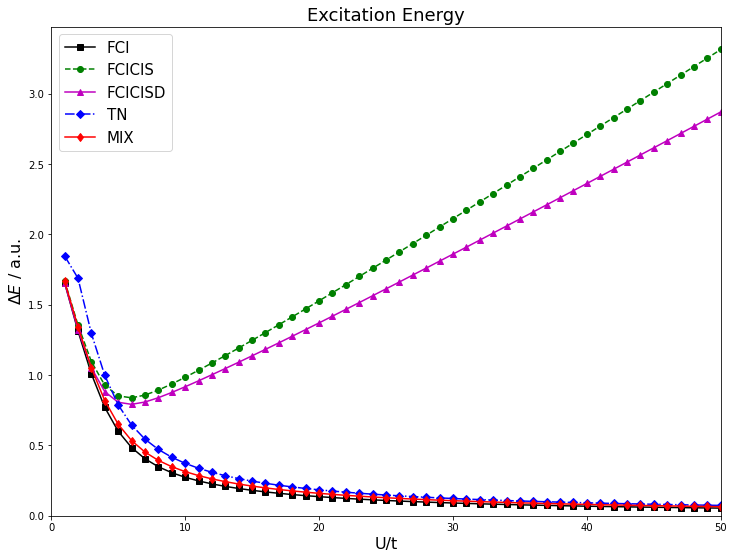

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))


plt.plot(df['U'], df['ext-FCI'], label='FCI', color='black', marker='s')
plt.plot(df['U'], df['ext-EOM'], label='FCICIS', color='green', linestyle='--', marker='o')
plt.plot(df['U'], df['ext-CISD'], linestyle='solid', marker='^', label='FCICISD', color='m')
plt.plot(df['U'], df['ext-TN'], label='TN', color='blue', linestyle='-.', marker='D')
plt.plot(df['U'], df['ext-MIX'], linestyle='solid', marker='d', label='MIX', color='red')
plt.legend(fontsize=15)
plt.xlabel(r"U/t", fontsize=16)
plt.ylabel(r'$\Delta E$ / a.u.', fontsize=16)
plt.xlim(0,50)
plt.ylim(0)
plt.title("Excitation Energy", fontsize=18)
plt.show()

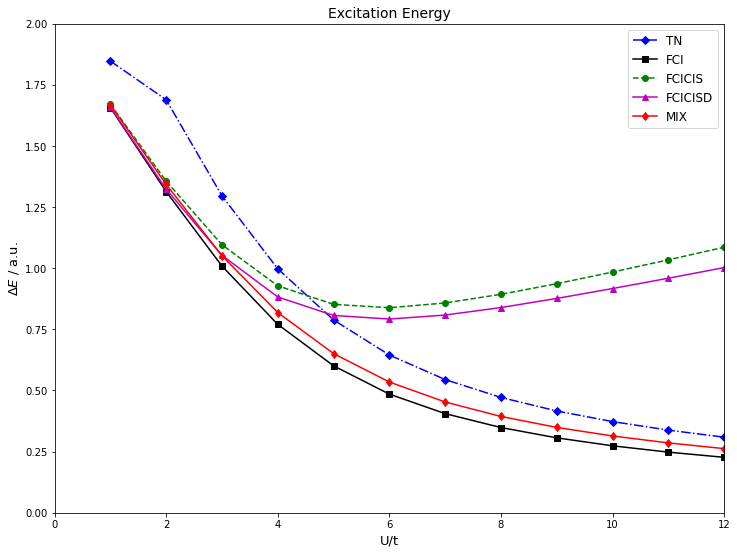

In [50]:
plt.figure(figsize=(12, 9))


plt.plot(df['U'], df['ext-TN'], label='TN', color='blue', linestyle='-.', marker='D')

plt.plot(df['U'], df['ext-FCI'], label='FCI', color='black', marker='s')
plt.plot(df['U'], df['ext-EOM'], label='FCICIS', color='green', linestyle='--', marker='o')
plt.plot(df['U'], df['ext-CISD'], linestyle='solid', marker='^', label='FCICISD', color='m')
plt.plot(df['U'], df['ext-MIX'], linestyle='solid', marker='d', label='MIX', color='red')

plt.legend(fontsize=12)
plt.xlabel(r"U/t", fontsize=13)
plt.ylabel(r'$\Delta E$ / a.u.', fontsize=13)
plt.xlim(0,12)
plt.ylim(0, 2)
plt.title("Excitation Energy", fontsize=14)
plt.show()

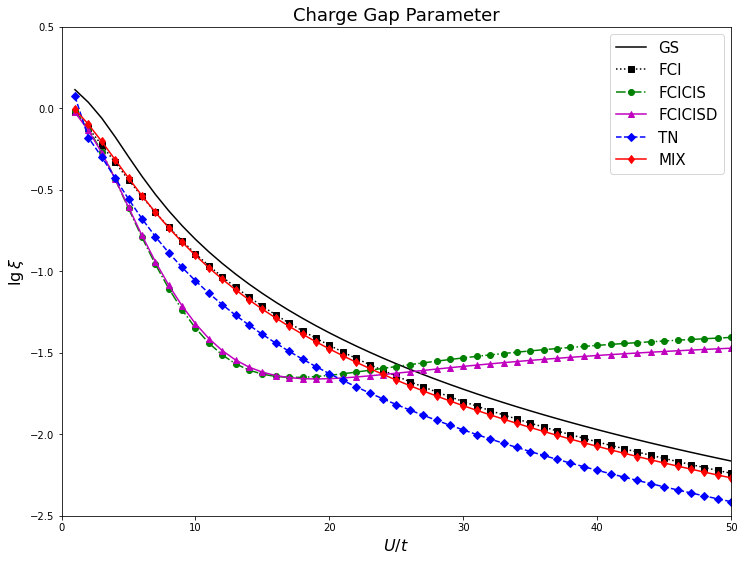

In [5]:
import numpy as np

plt.figure(figsize=(12,9))

plt.plot(df['U'], np.log10(df['int-GS']), label='GS', linestyle='solid', color='black')

plt.plot(df['U'], np.log10(df['int-FCI']), label='FCI', linestyle=':', color='black', marker='s')
plt.plot(df['U'], np.log10(df['int-EOM']), label='FCICIS', linestyle='-.', color='green', marker='o')
plt.plot(df['U'], np.log10(df['int-CISD']), label='FCICISD', linestyle='solid', marker='^', color='m')
plt.plot(df['U'], np.log10(df['int-TN']), label='TN', linestyle='--', color='blue', marker='D')
plt.plot(df['U'], np.log10(df['int-MIX']), linestyle='solid', marker='d', label='MIX', color='red')
plt.xlabel(r"$U/t$", fontsize=16)
plt.ylabel(r"$\lg \xi$", fontsize=16)
plt.legend(fontsize=15)
plt.title("Charge Gap Parameter", fontsize=18)
plt.ylim(-2.5,0.5)
plt.xlim(0,50)
plt.show()

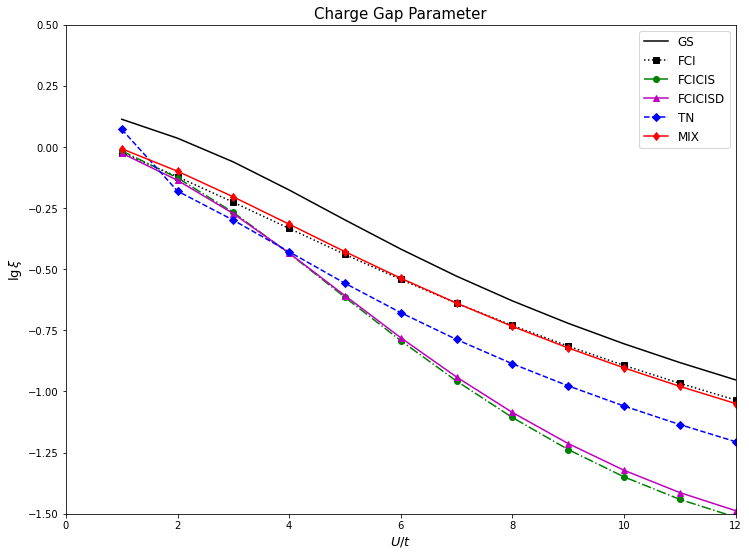

In [6]:
plt.figure(figsize=(12,9))


plt.plot(df['U'], np.log10(df['int-GS']), label='GS', linestyle='solid', color='black')
plt.plot(df['U'], np.log10(df['int-FCI']), label='FCI', linestyle=':', color='black', marker='s')
plt.plot(df['U'], np.log10(df['int-EOM']), label='FCICIS', linestyle='-.', color='green', marker='o')

plt.plot(df['U'], np.log10(df['int-CISD']), label='FCICISD', linestyle='solid', marker='^', color='m')
plt.plot(df['U'], np.log10(df['int-TN']), label='TN', linestyle='--', color='blue', marker='D')
plt.plot(df['U'], np.log10(df['int-MIX']), linestyle='solid', marker='d', label='MIX', color='red')


plt.xlabel(r"$U/t$", fontsize=13)
plt.ylabel(r"$\lg \xi$", fontsize=13)
plt.legend(fontsize=12)
plt.title("Charge Gap Parameter", fontsize=15)
plt.ylim(-1.5,0.5)
plt.xlim(0,12)
plt.show()